## Hyperparameter tuning via Optuna for Binary MLP model

### Being a binary model this notebook will be limited to predicting one class 1 or 0, yes or no.
### Here I will be predicting if a cell received a treatment or not

In [1]:
import sys
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import plotly
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn import preprocessing

from sklearn.model_selection import train_test_split

sys.path.append("..")
from MLP_utils.parameters import Parameters


from MLP_utils.utils import (
    Dataset_formatter,
    data_split,
    extract_best_trial_params,
    objective_model_optimizer,
    optimized_model_create,
    plot_metric_vs_epoch,
    results_output,
    test_optimized_model,
    train_optimized_model,
    un_nest,
)

from utils.utils import df_stats
from MLP_utils.utils import parameter_set
from configparser import ConfigParser

/home/lippincm/miniconda3/envs/Interstellar/lib/python3.10/site-packages/torch/cuda/__init__.py:88: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 9010). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at /opt/conda/conda-bld/pytorch_1670525552843/work/c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


In [2]:
# Import Data
# set data file path under pathlib path for multi-system use
file_path = Path(
    "../../Extracted_Features_(CSV_files)/interstellar_wave3_sc_norm_fs_cellprofiler.csv.gz"
)
df = pd.read_csv(
    file_path,
    low_memory=False,
)

In [3]:
config = ConfigParser()
config.optionxform = str
config.read("MLP_utils/config.ini")


params = Parameters()

params = parameter_set(params, config)
# int(params.DATA_SUBSET_NUMBER)

In [4]:
# Combine treatment with dosage to be able to discern treatments with different doses as a different condition
# Combine treatment and dose
df = df.assign(
    Metadata_Treatment_and_Dose=lambda x: df["Metadata_treatment"]
    + "_"
    + df["Metadata_dose"]
)

# df["Metadata_treatment"] = df["Metadata_treatment"] + "_" + df["Metadata_dose"]
print(df["Metadata_Treatment_and_Dose"].unique())

# Generate df speceific to analysis and model
df = df.query(
    "Metadata_Treatment_and_Dose == 'LPS_10µg/ml'| Metadata_Treatment_and_Dose == 'Media only_0'"
)
print(df["Metadata_Treatment_and_Dose"].unique())

df_stats(df)
# Drop na and reindex accordingly
df = df.dropna()
df = df.reset_index(drop=True)

# Check for Nans again
df_stats(df)
# Understand categorical data such as treatment and dosing
df[["Metadata_Treatment_and_Dose"]].drop_duplicates()
print(params.DATA_SUBSET_OPTION)
print(params.DATA_SUBSET_NUMBER)
if params.DATA_SUBSET_OPTION:
    df = df.sample(n=params.DATA_SUBSET_NUMBER)
else:
    pass

# Code snippet for metadata extraction by Jenna Tomkinson
df_metadata = list(df.columns[df.columns.str.startswith("Metadata")])

# define which columns are data and which are descriptive
df_descriptive = df[df_metadata]
df_values = df.drop(columns=df_metadata)

['LPS_10µg/ml' 'Disulfiram_2.5µM' 'LPS_1µg/ml' 'Disulfiram_0.1µM'
 'H2O2_500µM' 'Thapsi_10µM' 'H2O2_50µM' 'Thapsi_1µM' 'ATP_1mM'
 'LPS + Nigericin_1µg/ml + 10µM' 'ATP_0.1mM'
 'LPS + Nigericin_1µg/ml + 1µM' 'Flagellin_1µg/ml' 'DMSO 0.1%_0'
 'Flagellin_0.1µg/ml' 'Media only_0']
['LPS_10µg/ml' 'Media only_0']
The dimensions of the data are: (36718, 569)
Number of total missing values across all columns: 470
The dimensions of the data are: (36589, 569)
Number of total missing values across all columns: 0
False
1500


 ### Setting up data for network training

In [5]:
# Creating label encoder
le = preprocessing.LabelEncoder()
# Converting strings into numbers
df_values["Metadata_Treatment_and_Dose"] = le.fit_transform(
    df_descriptive["Metadata_Treatment_and_Dose"]
)
# split into X and Y where Y are the predictive column and x are the observable data
df_values_X = df_values.drop("Metadata_Treatment_and_Dose", axis=1)
df_values_Y = df_values["Metadata_Treatment_and_Dose"]

df_values_X.head()

X_train, X_test, X_val, Y_train, Y_test, Y_val = data_split(
    X_vals=df_values_X,
    y_vals=df_values_Y,
    train=0.8,
    val=0.1,
    test=0.1,
    seed=1,
)

In [6]:
# produce data objects for train, val and test datasets
train_data = Dataset_formatter(
    torch.FloatTensor(X_train.values), torch.FloatTensor(Y_train.values)
)
val_data = Dataset_formatter(
    torch.FloatTensor(X_val.values), torch.FloatTensor(Y_val.values)
)
test_data = Dataset_formatter(
    torch.FloatTensor(X_test.values), torch.FloatTensor(Y_test.values)
)

IN_FEATURES = X_train.shape[1]
print("Number of in features: ", IN_FEATURES)
OUT_FEATURES = len(df_values["Metadata_Treatment_and_Dose"].unique()) - 1
print("Number of out features: ", OUT_FEATURES)

Number of in features:  555
Number of out features:  1


In [7]:
# convert data class into a dataloader to be compatible with pytorch
train_loader = torch.utils.data.DataLoader(
    dataset=train_data, batch_size=params.BATCH_SIZE
)
valid_loader = torch.utils.data.DataLoader(
    dataset=val_data, batch_size=params.BATCH_SIZE
)
test_loader = torch.utils.data.DataLoader(
    dataset=test_data, batch_size=params.BATCH_SIZE
)

In [8]:
# wrap the objective function inside of a lambda function to pass args...
objective_lambda_func = lambda trial: objective_model_optimizer(
    train_loader,
    valid_loader,
    trial=trial,
    in_features=IN_FEATURES,
    out_features=OUT_FEATURES,
    params=params,
    metric="loss",
    return_info=False,
)
# Study is the object for model optimization
study = optuna.create_study(direction=f"{params.DIRECTION}")
# Here I apply the optimize function of the study to the objective function
# This optimizes each parameter specified to be optimized from the defined search space
study.optimize(objective_lambda_func, n_trials=params.N_TRIALS)
# Prints out the best trial's optimized parameters
objective_model_optimizer(
    train_loader,
    valid_loader,
    trial=study.best_trial,
    in_features=IN_FEATURES,
    out_features=OUT_FEATURES,
    params=params,
    metric=params.METRIC,
    return_info=True,
)

[I 2023-03-28 08:47:20,592] A new study created in memory with name: no-name-a5a18efd-b6ca-4109-85c0-3de935c46e68
[I 2023-03-28 08:47:22,552] Trial 0 finished with value: 0.7000388181209565 and parameters: {'n_layers': 7, 'n_units_l0': 9, 'dropout_0': 0.2172528688237627, 'n_units_l1': 3, 'dropout_1': 0.1684361821728212, 'n_units_l2': 9, 'dropout_2': 0.15475714634194, 'n_units_l3': 7, 'dropout_3': 0.29686719905233017, 'n_units_l4': 2, 'dropout_4': 0.3758293114719894, 'n_units_l5': 5, 'dropout_5': 0.2372372824160495, 'n_units_l6': 8, 'dropout_6': 0.32770227074454283, 'learning_rate': 0.42058970799158496, 'optimizer': 'Adam'}. Best is trial 0 with value: 0.7000388181209565.
[I 2023-03-28 08:47:24,246] Trial 1 finished with value: 0.6974609106779098 and parameters: {'n_layers': 3, 'n_units_l0': 3, 'dropout_0': 0.2558268182091479, 'n_units_l1': 8, 'dropout_1': 0.33699775495143147, 'n_units_l2': 6, 'dropout_2': 0.2731970317916646, 'learning_rate': 0.7911451798311284, 'optimizer': 'Adam'}. Be

Validation Accuracy: 50.0
Validation Loss: 0.852381380200386
Training Accuracy: 50.16500000000002
Training Loss: 184582.15838991464


In [9]:
optuna.visualization.plot_optimization_history(study)

In [10]:
optuna.visualization.plot_intermediate_values(study)

In [11]:
# call function for best trial parameter extraction
param_dict = extract_best_trial_params(study.best_params)

In [12]:
# call the optimized training model
train_loss, train_acc, valid_loss, valid_acc, epochs_ran, model = train_optimized_model(
    params.TRAIN_EPOCHS,
    train_loader,
    valid_loader,
    IN_FEATURES,
    OUT_FEATURES,
    param_dict,
    params,
)
# create a DataFrame of each stat
training_stats = pd.DataFrame(
    zip(train_loss, train_acc, valid_loss, valid_acc, epochs_ran),
    columns=["train_loss", "train_acc", "valid_loss", "valid_acc", "epochs_ran"],
)

RMSprop
RMSprop (
Parameter Group 0
    alpha: 0.99
    centered: False
    differentiable: False
    eps: 1e-08
    foreach: None
    lr: 0.5635586483391104
    maximize: False
    momentum: 0
    weight_decay: 0
)
Epoch 0: Validation loss decreased (inf --> 16.152294).  Saving model ...
	 Train_Loss: 206285184.3574 Train_Acc: 50.167 Val_Loss: 16.1523  BEST VAL Loss: 16.1523  Val_Acc: 50.000

Epoch 1: Validation loss decreased (16.152294 --> 8.422843).  Saving model ...
	 Train_Loss: 103142596.5691 Train_Acc: 50.167 Val_Loss: 8.4228  BEST VAL Loss: 8.4228  Val_Acc: 50.000

Epoch 2: Validation loss decreased (8.422843 --> 5.846282).  Saving model ...
	 Train_Loss: 68761731.2776 Train_Acc: 49.833 Val_Loss: 5.8463  BEST VAL Loss: 5.8463  Val_Acc: 50.000

Epoch 3: Validation loss decreased (5.846282 --> 4.558025).  Saving model ...
	 Train_Loss: 51571298.6313 Train_Acc: 50.583 Val_Loss: 4.5580  BEST VAL Loss: 4.5580  Val_Acc: 50.000

Epoch 4: Validation loss decreased (4.558025 --> 3.7851

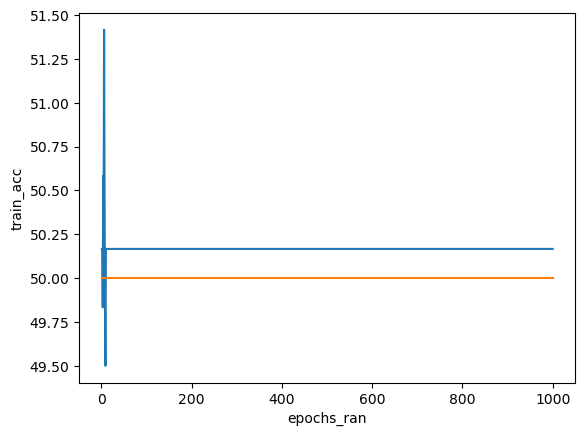

In [13]:
plot_metric_vs_epoch(training_stats, "epochs_ran", "train_acc", "valid_acc")

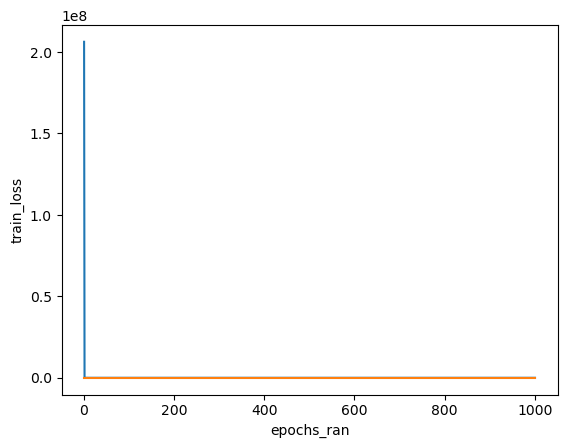

In [14]:
plot_metric_vs_epoch(training_stats, "epochs_ran", "train_loss", "valid_loss")

In [15]:
# calling the testing function and outputing list values of tested model
y_pred_list, y_pred_prob_list = test_optimized_model(
    model, test_loader, IN_FEATURES, OUT_FEATURES, param_dict, params
)

# un-nest list if nested i.e. length of input data does not match length of output data
if len(y_pred_list) != len(Y_test):
    y_pred_list = un_nest(y_pred_list)
    y_pred_prob_list = un_nest(y_pred_prob_list)
else:
    pass

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        75
           1       0.50      1.00      0.67        75

    accuracy                           0.50       150
   macro avg       0.25      0.50      0.33       150
weighted avg       0.25      0.50      0.33       150



/home/lippincm/miniconda3/envs/Interstellar/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/lippincm/miniconda3/envs/Interstellar/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/lippincm/miniconda3/envs/Interstellar/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



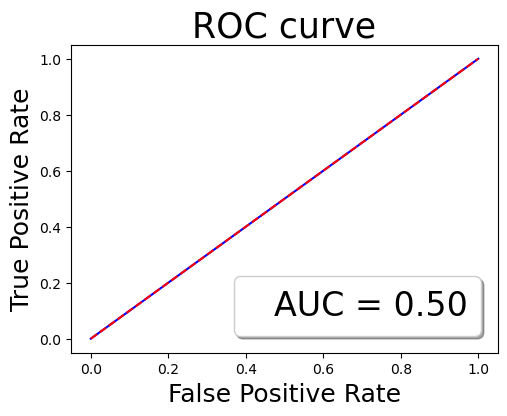

In [16]:
# Call visualization function
results_output(y_pred_list, y_pred_prob_list, Y_test)